# **\[Essays\]** 강화학습

신록예찬  
2023-08-02

## imports

In [26]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch 

## Game1

`-` 문제설명: 두개의 버튼이 있다. 버튼1을 누르면 1의 보상을, 버튼2를
누르면 100의 보상을 준다고 가정

In [27]:
action = np.random.choice(['button1','button2'])
action

In [28]:
if action == 'button1': 
    reward = 1 
else:
    reward = 100

In [29]:
for _ in range(10):
    action = np.random.choice(['button1','button2'])
    if action == 'button1': 
        reward = 1 
    else:
        reward = 100
    print(action,reward)

button2 100
button2 100
button2 100
button2 100
button2 100
button2 100
button2 100
button1 1
button1 1
button2 100

`-` 게임을 푸는 방법? 버튼2를 누른다.

`-` 용어 정리 - Agent = 버튼을 누르는 사람 - Action = 에이전트가 할 수
있는 행동 (현재는 2개의 action이 가능) - Env = Agent의 action을 보고
reward를 주는 존재 - 게임의 종료 = 버튼을 누르면 게임이 종료 - 게임을
푸는 방법 = reward를 최대화하는 action을 선택

## Game2

`-` 문제설명: 에이전트는 현재 2의 위치에 있다. 에이전트는 (1) 정지 (2)
왼쪽으로 이동 (3) 오른쪽으로 이동 하는 3개의 행동을 할 수 있다.
에이전트가 4의 위치에 도달하면 100의 보상을 얻고 게임이 종료된다.
에이전트가 0의 위치에 도달하면 보상없이 게임이 종료된다.

`-` 에이전트와 환경의 상호작용 구현1

In [30]:
state = 2

In [31]:
action = np.random.choice([0,1,2])

In [32]:
print(state,action)

2 2

In [33]:
for _ in range(9999): 
    if state == 2:
        print(state)
        reward = 200         
        print("2의 위치에 도달, 보상 {}점 획득".format(reward))
        break 
    elif state == -2:
        print(state)
        reward = 0 
        print("-2의 위치에 도달, 보상 {}점 획득".format(reward))
        break
    else:
        print(state,action)        
        state = state + action 
        action = np.random.choice(['<-','.','->'])
        

2
2의 위치에 도달, 보상 200점 획득

`-` 에이전트와 환경의 상호작용 구현2

In [9]:
gym.spaces.Discrete(3)

In [10]:
gym.spaces.Discrete?

In [11]:
class Game2(gym.Env):
    def __init__(self):
        self.action_space = gym.spaces.Discrete(3,start=-1) # Acition = {-1,0,1}  
        self.observation_space = gym.spaces.Discrete(5,start=-2) # State = {-2,-1,0,1,2} 
        self.state = 0 
        self.t = 0
    def step(self,action):
        self.state = self.state + action
        self.t = self.t + 1 
        if self.state == 2:
            reward = 100
        else:
            reward = -1
        info = {}
        if self.state == -2 or self.state==2: 
            done = True
        else: 
            done = False
        return self.state, reward, done, info
    def render(self):
        print('state: {}'.format(self.state))
    def reset(self):
        self.state = 0 
        return self.state

In [12]:
env=Game2()

## Game3

## Game4: LunarLander

### 환경만들기

`-` 환경을 만드는 방법은 아래와 같다.

In [13]:
env = gym.make('LunarLander-v2',render_mode='rgb_array')

`-` 환경에 대한 기본 정보를 조사하여 보자.

In [14]:
env.observation_space

In [15]:
env.action_space

### 환경관찰

`-` 환경관찰

In [16]:
env.reset()

In [17]:
env.step(0) # state, reward, done, _ 

`-` action

In [18]:
env.action_space.sample()

-   int형으로 전달

`-` action -\> nextstate, reward, done

In [19]:
env.step(env.action_space.sample())

In [20]:
frames = []
env.reset()
for _ in range(300):
    frames.append(env.render())
    env.step(env.action_space.sample())
env.close()

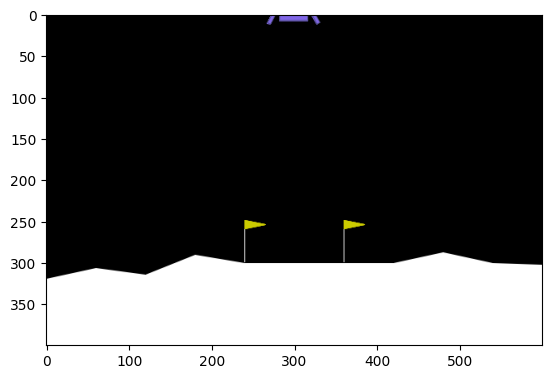

In [21]:
fig, ax = plt.subplots()
ani = FuncAnimation(fig,lambda i: ax.imshow(frames[::100][i]),frames=len(frames[::100]))

In [23]:
ani

### Replay Buffer

`-` 랜덤액션을 연속적으로 생성하고 그 결과를 기록해보자.

In [24]:
states = []
actions = []
rewards = []
next_states = []
dones = []

In [25]:
_state1 = env.reset()
for t in range(1500):
    _action = env.action_space.sample() 
    _state2, _reward, _done, _ = env.step(_action) 
    ## save code 
    states.append(_state1.tolist()) 
    actions.append(_action)
    rewards.append(_reward)
    next_states.append(_state2.tolist())
    dones.append(_done)
    ## save code end 
    _state1 = _state2 
    if _done:
        break

`-` 모인 히스토리를 확인해보자.

In [13]:
len(states), len(actions), len(next_states), len(rewards), len(dones)

### Qnetwork 설계

`-` 네트워크의 목적: 내가 여기서 뭘 해야하는지 알려줘! = 내가 이
상태에서, 어떠한 액션을 해야하는지 알려줘 $\to$ 8개의 상태를 입력으로
받으면 4개의 액션에 대한 좋은 정도를 숫자로 표현하는 어떠한 함수를
만들자.

`-` net 설계

In [14]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=8, out_features=128),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=128, out_features=64),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64, out_features=32),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=32, out_features=4)
)
net

In [15]:
net(torch.tensor(states))

### Policy 설계

`-` 네트워크의 의미

In [16]:
states[0],states[1]

In [17]:
net(torch.tensor(states[0:2]))

-   상태0에서는 액션0이, 상태1에서도 액션0이 가장 좋다는 의미 (왜?
    q-value가 젤 높으니까..)

`-` 따라서 Agent는 아래와 같이 행동해야 한다. (네트워크가 잘
학습되었다는 전제가 필요함) - state\[0\] -\> action = 0 - state\[1\] -\>
action = 0

In [18]:
net(torch.tensor(states[0:2])).max(axis=1)

In [19]:
net(torch.tensor(states[0:2])).max(axis=1)[1]

`-` 네트워크가 있으므로 이제 어떠한 state에 대해서도 뭘 해야할지 (=어떤
액션을 해야할지) 알 수 있다.

In [20]:
_state1 # 어떤 state에 대해서도.. 

In [21]:
net(torch.tensor(_state1)) # q-value를 계산할 수 있고 

In [22]:
int(torch.argmax(net(torch.tensor(_state1)))) # 그래서 다음에 우리가 어떤행동을 해야할 지 알 수 있음

### 학습

`-` 네트워크를 학습시키자.

In [23]:
net.to("cuda:0")

In [24]:
scores=[]
playtimes=[] 
eps = 1
opt = torch.optim.Adam(net.parameters(),lr=0.0001)

In [ ]:
for epsd in range(1,2001): # 게임 2000판 시켜줌.. 
    state1 = env.reset() # 환경리셋 + 초기화된 환경을 state라는 변수에 저장 
    score = 0 
    for t in range(1000): # 게임1판당 max 1000프레임만 할 수 있음
        # (step1) Agent: action 
        if np.random.rand() < eps: 
            action = env.action_space.sample() # 랜덤액션을 뽑음 
        else:
            action = int(torch.argmax(net(torch.tensor(state1).to("cuda:0")))) # 네트워크가 알려주는 action을 뽑음 
        
        # (step2) Agent -> Env // Env -> Agent 
        state2, reward, done, _ = env.step(action) # 액션을 환경에 전달 -> (next_state, reward, done) 을 받음 
        
        # (step3) Agnet: save data and learn 
        ## save data 
        states.append(state1.tolist())
        actions.append(action)
        rewards.append(reward)
        next_states.append(state2.tolist())
        dones.append(done)
    
        ## 최근 5000개의 자료만 준비함. 
        if len(states)>5000:
            _states = torch.tensor(states[-5000:])
            _actions = torch.tensor(actions[-5000:]).reshape(-1,1)
            _next_states = torch.tensor(next_states[-5000:])
            _rewards = torch.tensor(rewards[-5000:]).reshape(-1,1)
            _dones = torch.tensor(dones[-5000:]).to(torch.float).reshape(-1,1) 
        else:
            _states = torch.tensor(states)
            _actions = torch.tensor(actions).reshape(-1,1)
            _next_states = torch.tensor(next_states)
            _rewards = torch.tensor(rewards).reshape(-1,1)
            _dones = torch.tensor(dones).to(torch.float).reshape(-1,1)

        ## 최근 5000개의 자료에서 128개를 임의로 추출함. 
        _n = len(_states)
        _index = np.random.choice(_n,128) # 128 is batch_size 
        _states = _states[_index]
        _actions = _actions[_index]
        _next_states = _next_states[_index]
        _rewards = _rewards[_index]
        _dones = _dones[_index]
        
        ## GPU로 이동 
        _states = _states.to("cuda:0")
        _actions = _actions.to("cuda:0")
        _next_states = _next_states.to("cuda:0")
        _rewards = _rewards.to("cuda:0")
        _dones = _dones.to("cuda:0")
        
        ## leanrn with pytorch 
        yhat = net(_states).gather(1,_actions) ## (s,a) -> q(s,a) // 내가 현재상태 state에서, 현재 action을 하여 얻을 것이라 예상하는 보상 (net가 알려주는) 
        y = _rewards + 0.99 * net(_next_states).detach().max(1)[0].reshape(-1,1)*(1-_dones) ## 그런데 실제로는 이게 맞다고 봐야지~ 
        loss = torch.mean((y-yhat)**2)
        loss.backward()
        
        opt.step()
        opt.zero_grad()

        # (step4) Agent: prepare next steps 
        state1 = state2  
        eps = max(0.05, 0.99*eps) 
        score += reward
        
        # terminate 
        if done:
            scores.append(score)
            playtimes.append(t)
            break
            
    print('\rEpisode {}\tScore: {:.2f}\tPlaytime: {:.2f}'.format(epsd, scores[-1],playtimes[-1]), end="")
    if epsd % 100 == 0:
        print('\rEpisode {}\tScore: {:.2f}\tPlaytime: {:.2f}'.format(epsd, np.mean(scores[-100:]),np.mean(playtimes[-100])))

Episode 94  Score: -117.16  Playtime: 999.00